# The Most Dangerous Scoreline in Football - a Statistical Analysis of Football Scorelines

"2-0 is the most dangerous lead in football", a phrase that every football fan is sure to have heard more times than they care to count. But why is the use of this phrase such commonplace from commentators and fans alike? How did it become this way?

The concept behind the phrase is that the winning team may feel too 'comfortable', causing them to lose concentration or become less motivated. This can result in the opposition team scoring a goal to reduce the deficit to just one goal, at which point the opposition team also have the 'momentum' and are more likely to score again. It has also been hypothesised that the phrase may have been coined by broadcasters in an attempt to keep viewers interested in the game. So that's the theory behind the concept, but is there any evidence to support the idea that a two goal lead is in fact dangerous?

In this project we hope to answer this very question. To do so, we will create a model that can be used to calculate the probability of each outcome of a football game. That is, by using the minutes played as well as the current scoreline of any given game, find out the probability that a team will win, lose or draw. We will then explore the results of this model.


First import the relevant packages.

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Data

In order to create a model we first require data, for this project the data has come from: https://footystats.org/

We will use Premier League match data ranging from the 2007/08 season to the 2018/19 season. 
This comes in the form of 12 CSV files (one for each season) and are combined into a larger dataframe containing 4560 rows and 6 columns. Each row represents a single game. The columns represent:

- home_team_name; the name of the home team.
- away_team_name; the name of the away team.
- home_team_goal_count; the total number of goals scored by the home team. 
- away_team_goal_count; the total number of goals scored by the away team. 
- home_team_goal_timings; the time (in minutes) that each goal was scored by the home team,  separated by commas.
- away_team_goal_timings; the time (in minutes) that each goal was scored by the away team, separated by commas.


In [31]:
df1 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2007-to-2008-stats.csv")
df2 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2008-to-2009-stats.csv")
df3 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2009-to-2010-stats.csv")
df4 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2010-to-2011-stats.csv")
df5 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2011-to-2012-stats.csv")
df6 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2012-to-2013-stats.csv")
df7 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2013-to-2014-stats.csv")
df8 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2014-to-2015-stats.csv")
df9 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2015-to-2016-stats.csv")
df10 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2016-to-2017-stats.csv")
df11 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2017-to-2018-stats.csv")
df12 = pd.read_csv("/Users//ConorSharpe/Downloads/combine/england-premier-league-matches-2018-to-2019-stats.csv")


In [32]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12]) #Combine dataframes
df = df.reset_index()

df = pd.DataFrame({'home_team_name' : df['home_team_name'],
                    'away_team_name' : df['away_team_name'],
                    'home_team_goal_count' : df['home_team_goal_count'],
                    'away_team_goal_count' : df['away_team_goal_count'],
                    'home_team_goal_timings' : df['home_team_goal_timings'],
                    'away_team_goal_timings' : df['away_team_goal_timings'], }) #Create dataframe with only relevant columns
df.head()


,home_team_name,away_team_name,home_team_goal_count,away_team_goal_count,home_team_goal_timings,away_team_goal_timings
0,Sunderland,Tottenham Hotspur,1,0,90'3,NaN
1,West Ham United,Manchester City,0,2,NaN,"18,87"
2,Middlesbrough,Blackburn Rovers,1,2,30,"63,79"
3,Everton,Wigan Athletic,2,1,"26,75",80
4,Derby County,Portsmouth,2,2,"4,84","27,83"


# Scope of inference

Since our data comes from Premier League games only, we can only use it to predict the outcome of Premier League games. Games that take place in other countries or competitions may give different results.


# Methodology

Our model will take two inputs: minutes played and current goal difference. From here it will count the number of times that a game has had this scoreline at the given minutes played and find out what the final result of these games were. We will be able to calculate the probability of a team winning, losing or drawing based on what the current scoreline of the game.

For this project, we will not consider the exact scoreline but the current goal difference, i.e. winning 3-1 will be equivalent to winning 2-0. We will also consider all goals scored in added time to have been scored in the 45th or 90th minute (depending on which half they were scored) and assuming that every game finished after 90 minutes. We do this because the added time at the end of a football game varies in length, therefore this helps us maintain consistency.

# Data Tidying

In order to build our model, we will need to split the goal timings column into separate columns. The 'hg1' column will show the time that the first goal is scored by the home team, the 'hg2' column will show the time that the second goal is scored by the home team etc.


In [201]:

HGT = df.home_team_goal_timings.str.split(",").apply(pd.Series)
HGT.columns = ['hg1', 'hg2', 'hg3', 'hg4', 'hg5', 'hg6', 'hg7', 'hg8', 'hg9'] #Split goal times into seperate columns


HGT.head(5)
                     

,hg1,hg2,hg3,hg4,hg5,hg6,hg7,hg8,hg9
0,90'3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN


If we look in the first row of the first column we see a goal time of 90'3, this represents a goal scored in the third minute of added time. As stated above, we will record all goals scored in extra time as scored in the 90th minute. To do this we remove any character in the string after the second character.

An 'NaN' value in column means that the team did not score that many goals i.e. a 'NaN' in the hg1 column means that the home team did not score a first goal (thus they scored no goals) and so forth. In order to complete our analysis, we convert all 'NaN' values to 99 i.e. after the game has finished.

All values are then converted to floats.


In [34]:
HGT['hg1'] = HGT['hg1'].str[:2]
HGT['hg2'] = HGT['hg2'].str[:2]    
HGT['hg3'] = HGT['hg3'].str[:2]
HGT['hg4'] = HGT['hg4'].str[:2]
HGT['hg5'] = HGT['hg5'].str[:2]
HGT['hg6'] = HGT['hg6'].str[:2]
HGT['hg7'] = HGT['hg7'].str[:2]
HGT['hg8'] = HGT['hg8'].str[:2]
HGT['hg9'] = HGT['hg9'].str[:2] #Remove 'added time' from data

HGT = HGT.fillna(99) # Replace NaN with 99
HGT = HGT.astype(float) #Convert data to floats
HGT.head(5)

,hg1,hg2,hg3,hg4,hg5,hg6,hg7,hg8,hg9
0,90.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
1,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
2,30.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
3,26.0,75.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
4,4.0,84.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0


These steps are then repeated with the away goal timings column.

In [35]:
AGT = df.away_team_goal_timings.str.split(",").apply(pd.Series)
AGT.columns = ['ag1', 'ag2', 'ag3', 'ag4', 'ag5', 'ag6', 'ag7',]

AGT['ag1'] = AGT['ag1'].str[:2]
AGT['ag2'] = AGT['ag2'].str[:2]
AGT['ag3'] = AGT['ag3'].str[:2]
AGT['ag4'] = AGT['ag4'].str[:2]
AGT['ag5'] = AGT['ag5'].str[:2]
AGT['ag6'] = AGT['ag6'].str[:2]
AGT['ag7'] = AGT['ag7'].str[:2]


AGT = AGT.fillna(99)
AGT = AGT.astype(float)
AGT.head(5)

,ag1,ag2,ag3,ag4,ag5,ag6,ag7
0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
1,18.0,87.0,99.0,99.0,99.0,99.0,99.0
2,63.0,79.0,99.0,99.0,99.0,99.0,99.0
3,80.0,99.0,99.0,99.0,99.0,99.0,99.0
4,27.0,83.0,99.0,99.0,99.0,99.0,99.0


We then create a column showing the final result of each game. This contains either ‘HOME’ representing a home win, ‘AWAY’ representing an away win or ‘DRAW’ representing a draw.


In [36]:
df['goal_difference'] = df['home_team_goal_count']-df['away_team_goal_count'] #Create goal difference column

df['result'] = np.select([df['goal_difference'] > 0, df['goal_difference'] == 0, df['goal_difference'] < 0],
                        ['HOME', 'DRAW', 'AWAY']) #Create results column 

df.head()

,home_team_name,away_team_name,home_team_goal_count,away_team_goal_count,home_team_goal_timings,away_team_goal_timings,goal_difference,result
0,Sunderland,Tottenham Hotspur,1,0,90'3,NaN,1,HOME
1,West Ham United,Manchester City,0,2,NaN,"18,87",-2,AWAY
2,Middlesbrough,Blackburn Rovers,1,2,30,"63,79",-1,AWAY
3,Everton,Wigan Athletic,2,1,"26,75",80,1,HOME
4,Derby County,Portsmouth,2,2,"4,84","27,83",0,DRAW


The formatted data is then combine into a dataframe.

In [37]:
df_model = pd.concat([HGT, AGT], axis=1)
df_model['result'] = df['result']
df_model.head()  # Combine dataframes 

,hg1,hg2,hg3,hg4,hg5,hg6,hg7,hg8,hg9,ag1,ag2,ag3,ag4,ag5,ag6,ag7,result
0,90.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,HOME
1,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,18.0,87.0,99.0,99.0,99.0,99.0,99.0,AWAY
2,30.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,63.0,79.0,99.0,99.0,99.0,99.0,99.0,AWAY
3,26.0,75.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,80.0,99.0,99.0,99.0,99.0,99.0,99.0,HOME
4,4.0,84.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,27.0,83.0,99.0,99.0,99.0,99.0,99.0,DRAW


# Model building

First we need a function that will tell us the current goal difference of a game at minutes played, t. To do this we create the function home_goals(t), this returns a list of length 4560 with the number of goals scored by the home team at t. The function away_goals(t) does the same for goals scored by the away team. goal_diff(t) then subtracts away_goals(t) from home_goals(t) and returns a list of length 4560 with each game's goal difference. A positive value indicates the home team is winning at t and a negative value indicates the away team is winning at t. 


In [38]:
def home_goals (t):
            goals_list = []                #create empty list
            for i in range(0,4559):
                if (t >= df_model['hg9'][i]):
                    goals = 9
                elif (t >= df_model['hg8'][i]):
                    goals = 8
                elif (t >= df_model['hg7'][i]):
                    goals = 7
                elif (t >= df_model['hg6'][i]):
                    goals = 6    
                elif (t >= df_model['hg5'][i]):
                    goals = 5
                elif (t >= df_model['hg4'][i]):
                    goals = 4
                elif (t >= df_model['hg3'][i]):
                    goals = 3
                elif (t >= df_model['hg2'][i]):
                    goals = 2
                elif (t >= df_model['hg1'][i]):
                    goals = 1
                else: 
                    goals = 0          #find score at time t

                goals_list.append(goals)  #add score to list

            return(goals_list)          


In [39]:
def away_goals (t):
            goals_list = []                #create empty list
            for i in range(0,4559):
                if (t >= df_model['ag7'][i]):
                    goals = 7
                elif (t >= df_model['ag6'][i]):
                    goals = 6    
                elif (t >= df_model['ag5'][i]):
                    goals = 5
                elif (t >= df_model['ag4'][i]):
                    goals = 4
                elif (t >= df_model['ag3'][i]):
                    goals = 3
                elif (t >= df_model['ag2'][i]):
                    goals = 2
                elif (t >= df_model['ag1'][i]):
                    goals = 1
                else: 
                    goals = 0          #find score at time x

                goals_list.append(goals)  #add score to list

            return(goals_list)  

In [40]:
 def goal_diff (t):
        return (np.asarray(home_goals(t)) - np.asarray(away_goals(t)) )  #find difference between home and away goals in each match at time x


Next we create the function model(t, gd) which returns the probability of a team winning, drawing or losing. In order to find the probability of a team winning, we count the number of times a game has had the goal difference gd and the home team has won plus the total number of times a game has had the goal difference -gd and the away team has won. This is then divided by the total number of times the goal difference has been gd or -gd. This is repeated to find the probability of a draw and the probability of a loss.


In [64]:
def model (t, gd):

    def win_prob (t): 
            home = df['result'][np.where(goal_diff(t) == gd)[0]].tolist().count('HOME') #number of times the goal differnce is s and home team wins
            away = df['result'][np.where(goal_diff(t) == -gd)[0]].tolist().count('AWAY')  #number of times the goal differnce is -s and away team wins
            total = len(np.where(goal_diff(t) == gd)[0].tolist()) + len(np.where(goal_diff(t) == -gd)[0].tolist()) #number of times the goal difference is s or -s

            prob = (home + away) / total

            return(prob)

    def draw_prob (t): 
            home = df['result'][np.where(goal_diff(t) == gd)[0]].tolist().count('DRAW') #number of times the goal differnce is s and the game is a draw
            away = df['result'][np.where(goal_diff(t) == -gd)[0]].tolist().count('DRAW')  #number of times the goal differnce is -s and the game is a draw
            total = len(np.where(goal_diff(t) == gd)[0].tolist()) + len(np.where(goal_diff(t) == -gd)[0].tolist()) #number of times the goal difference is s or -s

            prob = (home + away) / total

            return(prob)

    def lose_prob (t): 
            home = df['result'][np.where(goal_diff(t) == gd)[0]].tolist().count('AWAY') #number of times the goal differnce is s and away team wins
            away = df['result'][np.where(goal_diff(t) == -gd)[0]].tolist().count('HOME')  #number of times the goal differnce is -s and home team wins
            total = len(np.where(goal_diff(t) == gd)[0].tolist()) + len(np.where(goal_diff(t) == -gd)[0].tolist()) #number of times the goal difference is s or -s

            prob = (home + away) / total

            return(prob)
    return([win_prob(t), draw_prob(t), lose_prob(t)])
   

 # Findings
 
Our final model requires two inputs: minutes played (t) and current goal difference (gd) then returns a list containing the win probability, draw probability and loss probability. For example, if we want to know the probability of each result in a scenario where a team is winning by one goal in the 53rd minute:

In [188]:
model(53, 1)

[0.7198093220338984, 0.2028601694915254, 0.07733050847457627]

We see the probability of the team winning is 0.72, the probability of drawing is 0.20 and the probability of losing is 0.08. 

Next we create a function that returns a list of win probabilities from t = 10 to t = 90 in 1 minute intervals, this makes it possible to plot the values.

In [89]:
x = np.linspace(10, 90 , 81)
def plot_model(gd):
    plot_list = []
    for t in x:
        plot = model(t, gd)[0]
        
        plot_list.append(plot)
       
    return(plot_list)

We create lists for the win probabilities when the goal difference in the game is 0, 1 and 2


In [90]:
x = np.linspace(10, 90 , 81)

In [69]:
y_0 = plot_model(0)

In [70]:
y_1 = plot_model(1)

In [71]:
y_2 = plot_model(2)

Below is the plot to show the probability of a team winning a game with no lead, a one goal lead and a two goal lead. We have chosen to start plotting the lines at t = 10, the reason for this is discussed later in the report.

Text(0, 0.5, 'Goal Difference')

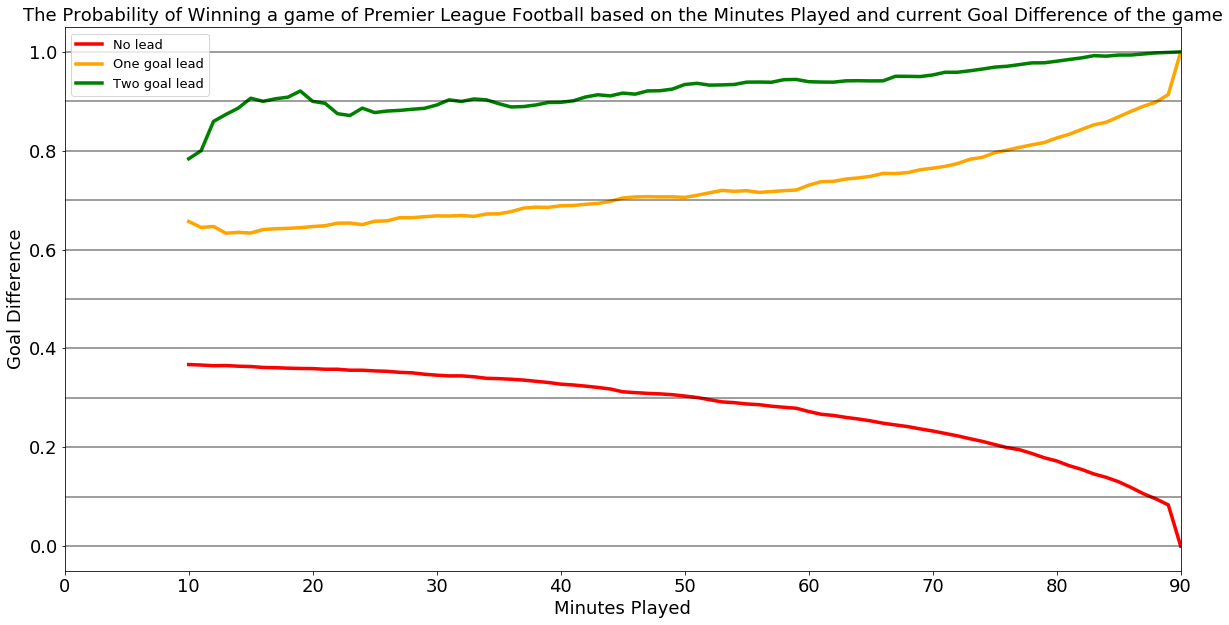

In [91]:
plt.figure(figsize=(20,10))

plt.plot(x, y_0, color = 'red', linewidth = 3.5, label = 'No lead ')
plt.plot(x, y_1, color = 'orange', linewidth = 3.5, label = 'One goal lead')
plt.plot(x, y_2, color = 'green', linewidth = 3.5, label = 'Two goal lead')
plt.legend(loc='upper left' , prop={'size': 13})

plt.plot([0, 90], [0, 0], color = 'black', alpha=0.5)
plt.plot([0, 90], [0.1, 0.1], color = 'black', alpha=0.5)
plt.plot([0, 90], [0.2, 0.2], color = 'black', alpha=0.5)
plt.plot([0, 90], [0.3, 0.3], color = 'black', alpha=0.5)
plt.plot([0, 90], [0.4, 0.4], color = 'black', alpha=0.5)
plt.plot([0, 90], [0.5, 0.5], color = 'black', alpha=0.5)
plt.plot([0, 90], [0.6, 0.6], color = 'black', alpha=0.5)
plt.plot([0, 90], [0.7, 0.7], color = 'black', alpha=0.5)
plt.plot([0, 90], [0.8, 0.8], color = 'black', alpha=0.5)
plt.plot([0, 90], [0.9, 0.9], color = 'black', alpha=0.5)
plt.plot([0, 90], [1, 1], color = 'black', alpha=0.5)

plt.xlim(0,90)

plt.tick_params(axis='both', which='major', labelsize=18)

plt.title('The Probability of Winning a game of Premier League Football based on the Minutes Played and current Goal Difference', fontsize=18)
plt.xlabel('Minutes Played', fontsize=18)
plt.ylabel('Goal Difference', fontsize=18)




To identify the ‘danger’ of a two goal lead we must look at the green line representing it. We see a team winning by two goals has approximately a 90% chance of winning the game from the 10th up to the 40th minute then from there it gradually increases to 100% in the 90th minute. This is anything but a dangerous scoreline. Therefore, as expected, the graph dispels the myth that "a two goal lead is the most dangerous scoreline in football".

Looking at the other lines on the plot, we see a team with a one goal lead has approximately a 65% chance of winning the game, rising gradually to 100% in the 90th minute. This line is below the two goal lead line for all values of t and therefore, by definition, is more ‘dangerous’.

A team with no lead has approximately a 35% chance of winning the game dropping gradually to 0% at 90 minutes. 

Looking at the lines representing a one goal lead and no lead, we see an increase in the gradient in the final few minutes of the game, this is because a high proportion of goals in football are scored in the final few minutes. We also see a sharp jump in the win probabilities between the 89th and 90th minute for both the one goal lead and no lead, this is caused by the decision to consider all goals scored in added time to have been scored in the 90th minute so we get an artificially inflated figure for goals scored in the 90th minute.

Next we will attempt to quantify the value of each scoreline. In order to do this we will create an expected points model, this aims to show how many points a team can expect to receive from a game based on the same inputs as before. To do this we multiply the probability of winning the game by three (three points for a win in the Premier League), multiply the probability of drawing the game by one (one point for a draw) and then add these values together. 

In [171]:
def xPTS (t, gd):
    return(3*model(t, gd)[0] + model(t, gd)[1])

For example, given the same scenario as above: a team is winning by one goal in the 53rd minute, we can find the expected points like so:

In [187]:
xPTS(53, 1)

2.3622881355932206

So the team can expect to receive 2.36 points from the game.

We will now plot lines representing the expected points of a team winning by two goals, winning by one goal, drawing, losing by one goal and losing by two goals. Like before, we are plotting the values for each minute from the 10th to the 90th.

In [175]:
x = np.linspace(10, 90 , 81)
def plot_xPTS(gd):
    plot_list = []
    for t in x:
        plot = Xg_pts(t, gd)
        
        plot_list.append(plot)
       
    return(plot_list)

First we generate the lists of points for our line graphs.

In [176]:
z_0 = plot_xPTS(0)

In [177]:
z_1 = plot_xPTS(1)

In [178]:
z_2 = plot_xPTS(2)


In [179]:
z_neg1 = plot_xPTS(-1)

In [180]:
z_neg2 = plot_xPTS(-2)

Below you can see the expected points of a team plotted for a number of different scorelines.

Text(0, 0.5, 'Minutes Played')

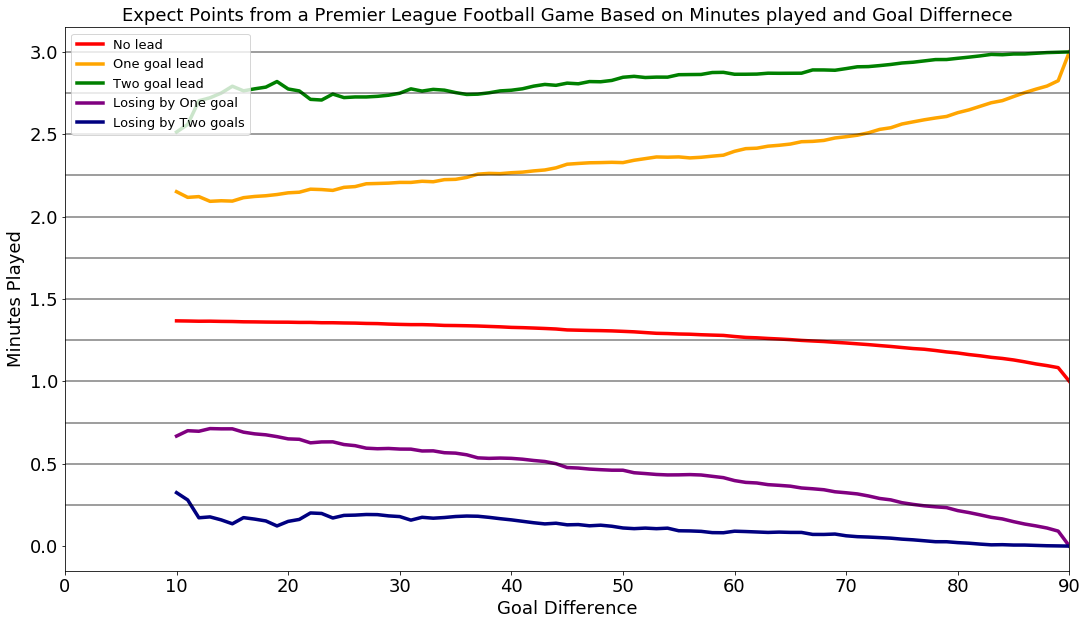

In [194]:
plt.figure(figsize=(18,10))

plt.plot(x, z_0, color = 'red', linewidth = 3.5, label = 'No lead ')
plt.plot(x, z_1, color = 'orange', linewidth = 3.5, label = 'One goal lead')
plt.plot(x, z_2, color = 'green', linewidth = 3.5, label = 'Two goal lead')
plt.plot(x, z_neg1, color = 'purple', linewidth = 3.5, label = 'Losing by One goal')
plt.plot(x, z_neg2, color = 'navy', linewidth = 3.5, label = 'Losing by Two goals')
plt.legend(loc='upper left' , prop={'size': 13})

plt.plot([0, 90], [0.25, 0.25], color = 'black', alpha=0.5)
plt.plot([0, 90], [0.5, 0.5], color = 'black', alpha=0.5)
plt.plot([0, 90], [0.75, 0.75], color = 'black', alpha=0.5)
plt.plot([0, 90], [1, 1], color = 'black', alpha=0.5)
plt.plot([0, 90], [1.25, 1.25], color = 'black', alpha=0.5)
plt.plot([0, 90], [1.5, 1.5], color = 'black', alpha=0.5)
plt.plot([0, 90], [1.75, 1.75], color = 'black', alpha=0.5)
plt.plot([0, 90], [2, 2], color = 'black', alpha=0.5)
plt.plot([0, 90], [2.25, 2.25], color = 'black', alpha=0.5)
plt.plot([0, 90], [2.5, 2.5], color = 'black', alpha=0.5)
plt.plot([0, 90], [2.75, 2.75], color = 'black', alpha=0.5)
plt.plot([0, 90], [3, 3], color = 'black', alpha=0.5)



plt.xlim(0,90)

plt.tick_params(axis='both', which='major', labelsize=18)

plt.title('Expect Points from a Premier League Football Game Based on Minutes played and Goal Differnece', fontsize=18)
plt.xlabel('Goal Difference' , fontsize=18)
plt.ylabel('Minutes Played', fontsize=18)




Firstly, as you would expect, we see the more goals a team is winning by the higher the points they can expect to win. The one and two goal lead lines end at three (three points for a win), the no lead line ends at one (one point for a draw) and the losing by one and two goal lines end at zero (zero points for a draw). 

The lines representing the expected points are not flat, this means the points a team can expect to receive is affected by the minutes played, when the current goal difference is held constant. The expected points for teams that are winning increases as minutes played increases and the expected points for teams that are losing or drawing decreases as minutes played increases. Because of this, a goal scored at one point in the game is worth a different amount of expected points to a goal scored at another.

As well as being affected by the timing, we see the value of a goal is affected by the current scoreline. The increase (or decrease) in the points a team can expect to receive when a goal is scored (or conceded) is represented by the gap between two lines. We see that there is a large increase in expected points by going from losing by one goal to drawing or drawing to winning by one goal. This means that, in terms of expected points, these are the most valuable goals to score. Going from losing by two goals to one goal and going from winning by one goal to two goals has a smaller impact on the points a team can expect. This pattern continues for games with higher scorelines (this is not plotted as the graph is already relatively complex). Therefore, each goal scored after taking the lead in a game is less valuable than the previous goal scored. In a future article, we will go into more detail on the effects of scoring or conceding a goal for a number of different scorelines.

By this point most readers are probably confident that a 2-0 lead is not particularly ‘dangerous’. However, just to show how ‘safe’ the lead is, we will look at the line which represents a two goal lead; we see a team can expect to receive approximately 2.75 points up until the 40th minute rising gradually to 3 in the 90th minute. Therefore, if a team were to take a ‘dangerous’ two goal lead at any point in a game, they can expect a minimum of 2.75 points. If this were to happen in every one of the 38 games a team plays in a premier league season they would expect to end the season with 104.5 points, 4.5 points more than the current record for points total in a single premier league season set by Manchester City in 2018/19. 


# Limitations

Obviously no model is perfect, we will now look at a number of limitations of this particular model.

#### Added time 
We consider all goals scored in added time to have been scored in the 45th or 90th minute (depending on which half they were scored) and assuming that every game finished after 90 minutes. This causes us to see a jump in probability from the 89th minute to the 90th minute. The model assumes a team winning in the 90th minute is guaranteed to win, however we know this is not the case.

#### Sample size 
Although the dataset contains 4560 games of football (which would be considered a large sample size), not many of these games contained goals very early in the game. For example if we look at games in which a team was winning by two goals in the 5th minute: 

In [203]:
len(np.where(goal_diff(5) == 2)[0].tolist()) + len(np.where(goal_diff(5) == -2)[0].tolist())

10

We see this occurred in only 10 of the 4560 games, thus we have a sample size of 10. This means each sample point (game) has a large effect on the result of the model. This is why we see the graphs are plotted from 10 minutes onwards, as values below this point are less valid.
It also explains the fluctuation in findings for lower values in the line representing a two goal lead. 

#### Precision of the model
There are a huge number of factors that will affect how likely a team is to win a game of football, our model takes just two of these into account: minutes played and current goal difference. In a future project we will investigate ways to improve the model. However, this improvement will be in direct contradiction with the limitation mentioned above, if we start introducing more variables that will split up the database then the sample size will be reduced further.

